## Rapidly Prototyping a Machine Learning Pipeline

The purpose of this workshop is to show how easy it is to take an idea and turn it into a successful Machine Learning application.

In [27]:
import pandas as pd
pd.options.display.max_colwidth = 0

import matplotlib
%matplotlib inline

# this is a trick to parallelize our computations
import multiprocessing
NCPUS = 8 if multiprocessing.cpu_count() > 8 else (multiprocessing.cpu_count() - 1)

In [ ]:
# this cell will (ideally) install NLTK
# and download the english stopwords.
!pip install nltk
import nltk
nltk.download('stopwords')

### Part 1: The idea/loading data
In line with Tuesday's panel around "autocoders," we'll demonstrate how to use text descriptions to predict codes. Along the way, we'll show some good practice when practicing machine learning. While this notebook will focus on coding products using descriptions, this approach should work for many scenarios where one has a dataset with both text descriptions and their associated codes.

#### The data
This data comes from Census' own Foreign Trade site: https://www.census.gov/foreign-trade/schedules/b/index.html#download

Specifically, this is the "concordance file" for the Harmonized System's import/export codes. This gives us the code and a description of what products fit into that code: perfect for the sort of automatic coding we want to do. We've included the file here (in the `data/` subfolder) for ease-of-use.

The import and export codes are slightly different at the 10-digit level; however, the codes are heirarchical and at the 6-digit level they are the same (as defined by an international standards group). We'll model at an even less granular level than that - the 4-digit level - based on the amount of data that we have.

First, let's take a look in a text editor. Jupyter has one that's enough for this.

From here, taking a look at the `imp-stru.txt` file will give us the "schema."

Now, we'll use a combination of python and pandas to ingest and clean this data.

In [2]:
# we develop this by looking at the 'imp-stru.txt' file. the export structure is also the same
def process_impexp_line(line, which='import'):
    hs_code = line[:10]
    short_desc = line[14:65]
    long_desc = line[69:219]
    return (hs_code, short_desc, long_desc)

In [3]:
# this is one way of reading / processing a file in python
with open("data/imp-code.txt") as imp_f:
    imp_lines = []
    for line in imp_f:
        imp_lines.append(process_impexp_line(line))
        
# let's take a look. Note all the extra whitespace. We'll have to remove that.
imp_lines[:3]

[('0101210010',
  'HORSES AND ASSES, PUREBRED BREEDING, MALE, LIVE    ',
  'HORSES AND ASSES, PUREBRED BREEDING, MALE, LIVE                                                                                                       '),
 ('0101210020',
  'HORSES AND ASSES, PUREBRED BREEDING, FEMALE, LIVE  ',
  'HORSES AND ASSES, PUREBRED BREEDING, FEMALE, LIVE                                                                                                     '),
 ('0101290010',
  'HORSES, FOR IMMEDIATE SLAUGHTER, LIVE, NESOI       ',
  'HORSES, IMPORTED FOR IMMEDIATE SLAUGHTER, LIVE, EXCEPT PUREBRED BREEDING                                                                              ')]

In [5]:
# this is a slightly fancier way of doing the same thing
with open("data/exp-code.txt") as exp_f:
    exp_lines = [process_impexp_line(line) for line in exp_f]
        
# always good to take a look at things along the way
exp_lines[:3]

[('0101210000',
  'HORSES, PUREBRED BREEDING, LIVE                    ',
  'HORSES, PUREBRED BREEDING, LIVE                                                                                                                       '),
 ('0101290000',
  'HORSES, LIVE, EXCEPT PUREBRED BREEDING             ',
  'HORSES, LIVE, EXCEPT PUREBRED BREEDING                                                                                                                '),
 ('0101300000',
  'ASSES, LIVE                                        ',
  'ASSES, LIVE                                                                                                                                           ')]

Now that we've got two lists (`imp_lines` and `exp_lines`) that hold all of the codes and descriptions, let's put them in a data frame and start processing/looking around.

In [6]:
all_lines = imp_lines + exp_lines

In [7]:
# as you can see in the output, pandas is smart enough to take a list of tuples
# and turn it into a table in a "sensible" way. We do need to specify column names though.
df = pd.DataFrame(all_lines)
df.head(2)

,0,1,2
0,0101210010,"HORSES AND ASSES, PUREBRED BREEDING, MALE, LIVE","HORSES AND ASSES, PUREBRED BREEDING, MALE, LIVE"
1,0101210020,"HORSES AND ASSES, PUREBRED BREEDING, FEMALE, LIVE","HORSES AND ASSES, PUREBRED BREEDING, FEMALE, LIVE"


In [8]:
df = pd.DataFrame(all_lines, columns=['HS10', 'short_desc', 'long_desc'])
print("df has", len(df), "rows")
print("df has", df['HS10'].nunique(), 'unique HS 10-digit codes')
df.head()

df has 28469 rows
df has 22660 unique HS 10-digit codes


,HS10,short_desc,long_desc
0,0101210010,"HORSES AND ASSES, PUREBRED BREEDING, MALE, LIVE","HORSES AND ASSES, PUREBRED BREEDING, MALE, LIVE"
1,0101210020,"HORSES AND ASSES, PUREBRED BREEDING, FEMALE, LIVE","HORSES AND ASSES, PUREBRED BREEDING, FEMALE, LIVE"
2,0101290010,"HORSES, FOR IMMEDIATE SLAUGHTER, LIVE, NESOI","HORSES, IMPORTED FOR IMMEDIATE SLAUGHTER, LIVE, EXCEPT PUREBRED BREEDING"
3,0101290090,"HORSES, LIVE, NESOI","HORSES, LIVE, NESOI"
4,0101300000,"ASSES, LIVE","ASSES, LIVE"


Great. We have something like 28,000 rows. As we can immediately see, there is some overlap between the 10-digit import and export codes, hence the only ~22,000 unique 10-digit codes. It is likely that duplicate codes have the same description in both files... and from the perspective of the model, 2 copies of the same description/code is just as good as 1, so we'll only want to retain one copy of those. Additionally, we need to standardize and process this text, which will probably leave us with more of duplicate text strings as well. Let's start processing and find out.

#### Part 2: Cleaning / processing the data

There are two main libraries for cleaning and processing text data in Python:
- `spaCy`
- `nltk`
In this case, we'll use nltk, but spaCy is equally as good.

Additionally, depending on the type of text that you have, there are many different ways to process and "extract features" (i.e. create variables for modelling) from that text. For example, if you're working with phrases/sentences, spaCy has good tools for determining which part-of-speech each word in a sentence maps to.

In our case, we have very simple product descriptions (perhaps closer to "tags" than sentences), so less processing is required. We'll start out by using regular expressions. This is a good tutorial to learn more about those: https://www.datacamp.com/community/tutorials/python-regular-expression-tutorial

In [9]:
# we'll do this step-by-step, to illustrate
df['long_stripped'] = df['long_desc'].str.strip()

# this is pulling 5 random rows, instead of the top 5, just for some variety
# note the new colummn
df.sample(3)

,HS10,short_desc,long_desc,long_stripped
3278,2508700000,CHAMOTTE OR DINAS EARTH,CHAMOTTE OR DINAS EARTH,CHAMOTTE OR DINAS EARTH
9329,6001920040,OTHER PILE FABRIC MMF OTH LT 271 G/M2 KNIT/CROCHET,"OTHER PILE FABRIC, OF MAN-MADE FIBERS, KNITTED OR CROCHETED, NOT OVER 271 G/M2, NOT VELOUR","OTHER PILE FABRIC, OF MAN-MADE FIBERS, KNITTED OR CROCHETED, NOT OVER 271 G/M2, NOT VELOUR"
16052,8481809020,"ELECTRICAL ACTUATOR, NESOI,OPERT BY SIG. FM CNTL",ELECTRICAL OR ELECTRO-HYDRAULIC ACTUATORS WITH CONTROL VALVES DESIGNED FOR PROPORTIONAL OPERATION BY A SIGNAL FROM A CONTROL DEVICE,ELECTRICAL OR ELECTRO-HYDRAULIC ACTUATORS WITH CONTROL VALVES DESIGNED FOR PROPORTIONAL OPERATION BY A SIGNAL FROM A CONTROL DEVICE


In [10]:
df['long_lower'] = df['long_stripped'].str.lower()

df.head(2)

,HS10,short_desc,long_desc,long_stripped,long_lower
0,0101210010,"HORSES AND ASSES, PUREBRED BREEDING, MALE, LIVE","HORSES AND ASSES, PUREBRED BREEDING, MALE, LIVE","HORSES AND ASSES, PUREBRED BREEDING, MALE, LIVE","horses and asses, purebred breeding, male, live"
1,0101210020,"HORSES AND ASSES, PUREBRED BREEDING, FEMALE, LIVE","HORSES AND ASSES, PUREBRED BREEDING, FEMALE, LIVE","HORSES AND ASSES, PUREBRED BREEDING, FEMALE, LIVE","horses and asses, purebred breeding, female, live"


In [11]:
import re
# this is in general one of the more useful regular expressions to know
# the '\w' searches for word-like tokens, and the '+' says "one or more"
# combined, this gets us 'one or more characters', i.e. word tokens w/o commas, spaces, etc.
WORD_REGEX = r'\w+'

def find_words(desc):
    return re.findall(WORD_REGEX, desc)
df['long_word_list'] = df['long_lower'].apply(find_words)
df['long_words_only'] = df['long_word_list'].str.join(' ')

df.head()

,HS10,short_desc,long_desc,long_stripped,long_lower,long_word_list,long_words_only
0,0101210010,"HORSES AND ASSES, PUREBRED BREEDING, MALE, LIVE","HORSES AND ASSES, PUREBRED BREEDING, MALE, LIVE","HORSES AND ASSES, PUREBRED BREEDING, MALE, LIVE","horses and asses, purebred breeding, male, live","[horses, and, asses, purebred, breeding, male, live]",horses and asses purebred breeding male live
1,0101210020,"HORSES AND ASSES, PUREBRED BREEDING, FEMALE, LIVE","HORSES AND ASSES, PUREBRED BREEDING, FEMALE, LIVE","HORSES AND ASSES, PUREBRED BREEDING, FEMALE, LIVE","horses and asses, purebred breeding, female, live","[horses, and, asses, purebred, breeding, female, live]",horses and asses purebred breeding female live
2,0101290010,"HORSES, FOR IMMEDIATE SLAUGHTER, LIVE, NESOI","HORSES, IMPORTED FOR IMMEDIATE SLAUGHTER, LIVE, EXCEPT PUREBRED BREEDING","HORSES, IMPORTED FOR IMMEDIATE SLAUGHTER, LIVE, EXCEPT PUREBRED BREEDING","horses, imported for immediate slaughter, live, except purebred breeding","[horses, imported, for, immediate, slaughter, live, except, purebred, breeding]",horses imported for immediate slaughter live except purebred breeding
3,0101290090,"HORSES, LIVE, NESOI","HORSES, LIVE, NESOI","HORSES, LIVE, NESOI","horses, live, nesoi","[horses, live, nesoi]",horses live nesoi
4,0101300000,"ASSES, LIVE","ASSES, LIVE","ASSES, LIVE","asses, live","[asses, live]",asses live


To clean things up a bit, let's get rid of some of these intermediate columns.

In practice, this is a useful thing to do because it will free up memory. If you find your code is using too much memory or is running very slow, then consider deleting unnecessary columns in this manner.

In [12]:
# running this cell more than once will cause an error
# because when you try to delete somethat that has 
# already been deleted, it's no longer there
del df['long_stripped']
del df['long_lower']
del df['long_word_list']

df.head()

,HS10,short_desc,long_desc,long_words_only
0,0101210010,"HORSES AND ASSES, PUREBRED BREEDING, MALE, LIVE","HORSES AND ASSES, PUREBRED BREEDING, MALE, LIVE",horses and asses purebred breeding male live
1,0101210020,"HORSES AND ASSES, PUREBRED BREEDING, FEMALE, LIVE","HORSES AND ASSES, PUREBRED BREEDING, FEMALE, LIVE",horses and asses purebred breeding female live
2,0101290010,"HORSES, FOR IMMEDIATE SLAUGHTER, LIVE, NESOI","HORSES, IMPORTED FOR IMMEDIATE SLAUGHTER, LIVE, EXCEPT PUREBRED BREEDING",horses imported for immediate slaughter live except purebred breeding
3,0101290090,"HORSES, LIVE, NESOI","HORSES, LIVE, NESOI",horses live nesoi
4,0101300000,"ASSES, LIVE","ASSES, LIVE",asses live


#### Part 3: Initial Model
Now that we've gotten English words only, we can try a simple model. Let's get into the modelling approach and the package that we'll use to implement it, `scikit-learn`.

#We'll be implementing a _bag-of-words_ model. The idea is very simple: each word becomes a separate variable. For each variable, the value is the number of times that word occurs in that particular record. Let's demonstrate with a quick example.

In [13]:
# let's try this process on the first few and see what we get back
first_few_only = df.head()
# look at the final results, for reference
first_few_only['long_words_only']

0    horses and asses purebred breeding male live                         
1    horses and asses purebred breeding female live                       
2    horses imported for immediate slaughter live except purebred breeding
3    horses live nesoi                                                    
4    asses live                                                           
Name: long_words_only, dtype: object

In [14]:
# scikit-learn calls this process "vectorizing", i.e. turning a sentence into a vector of variables.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cv = CountVectorizer()
# this will actually convert our first few descriptions into vectors
tfd = cv.fit_transform(first_few_only['long_words_only'])
# by default, it's a sparse matrix
tfd.toarray()

array([[1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0],
       [1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0],
       [0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]], dtype=int64)

For explainability, let's cleanly present this mapping:

In [15]:
# don't worry about this, it's for pedagogical purposes
columns = [x[0] for x in sorted(list(cv.vocabulary_.items()), key=lambda x: x[1])]
pd.DataFrame(tfd.toarray(), columns=columns, index=first_few_only['long_words_only'])

,and,asses,breeding,except,female,for,horses,immediate,imported,live,male,nesoi,purebred,slaughter
long_words_only,,,,,,,,,,,,,,
horses and asses purebred breeding male live,1,1,1,0,0,0,1,0,0,1,1,0,1,0
horses and asses purebred breeding female live,1,1,1,0,1,0,1,0,0,1,0,0,1,0
horses imported for immediate slaughter live except purebred breeding,0,0,1,1,0,1,1,1,1,1,0,0,1,1
horses live nesoi,0,0,0,0,0,0,1,0,0,1,0,1,0,0
asses live,0,1,0,0,0,0,0,0,0,1,0,0,0,0


Now that we get the idea, let's do this for the entire dataset and see what it looks like.

In [16]:
cv = CountVectorizer()
cv.fit_transform(df["long_words_only"])

<28469x12054 sparse matrix of type '<class 'numpy.int64'>'
	with 347471 stored elements in Compressed Sparse Row format>

We won't try to convert this into an array as above, because it would be very memory-intensive. But we can see we have 12,054 unique words.

Now, we have variables. But what what exactly are we going to model? The trade-off is that the more digits of the HS code we use, the fewer records there are within each code that the model can learn from. We aren't using any heirarchical information here, so each HS code is a completely separate category from the model's perspective. Let's extract 2-digit, 4-digit, and 6-digit harmonized codes in our DataFrame.

,HS2
count,98.000000
mean,290.500000
std,411.851396
min,2.000000
25%,85.250000
50%,160.000000
75%,307.500000
max,2904.000000


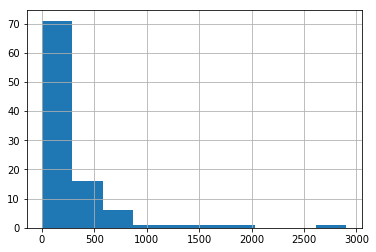

In [65]:
df["HS2"] = df["HS10"].str[:2]
df["HS4"] = df["HS10"].str[:4]
df["HS6"] = df["HS10"].str[:6]

# we'll look at the distribution of # of records in each class at the 4-digit level.
# Remember, we haven't de-duplicated, so this estimate is a bit high
df.HS2.value_counts().hist()
df.HS2.value_counts().describe().to_frame()

We see that some categories do have only 2 descriptions. Let's see how many there are:

In [67]:
vcs = df.HS2.value_counts()
print(len(vcs[vcs == 2]), "codes with only 2 descs")
vcs[vcs == 2]

1 codes with only 2 descs


99    2
Name: HS2, dtype: int64

Chapter 99 looks to be a very specific category, so we'd probably want to think more carfeully before classifying those. 


#### Training / test sets
As a bare minimum, we need at least 2 records in any category we want to attempt to model. This is because we need to split our data into two pieces: the _training set_, which we'll develop the model on, and the _test set_, which we'll subsequently evaluate it on. We want to see how the model performs on descriptions it's never seen before.

In practice, we almost certainly want more than 2, but we'll continue along here.

In addition, [_cross validation_](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6), which we won't get into today, is an important technique in machine learning that prevents us from "overfitting" the model to the sample of data we're using. It's easy to do in python with `scikit-learn`.

In [71]:
from sklearn.model_selection import train_test_split

# we make these functions so we can reuse them later
def make_test_train(df, column_name, y_column):
    # first, let's remove duplicates
    print("initially, we have", len(df), "records")
    deduped = df.drop_duplicates(subset=["long_words_only"])
    print("after deduping, we have", len(deduped), "records")

    #now, let's remove any HS4 category with <2 records
    vcs = deduped[y_column].value_counts()
    to_include = vcs[vcs > 2].index
    final_dataset = deduped[deduped[y_column].isin(to_include)]
    print("after removing <3 record categories, there are", len(final_dataset), "records")

    # the stratify is important -- 
    # it's making sure that we have an instance of each category in both the train and test sets

    train, test = train_test_split(final_dataset, stratify=final_dataset[y_column], random_state=42)
    print("training set has", len(train), "records --", 100 * len(train) / len(final_dataset), 
          "percent -- and test set has", len(test), "records")
    
    return train, test
train, test = make_test_train(df, "long_words_only", "HS2")

initially, we have 28469 records
after deduping, we have 22372 records
after removing <3 record categories, there are 22370 records
training set has 16777 records -- 74.99776486365668 percent -- and test set has 5593 records


Now that we've split up our data, we can choose a classifier. We'll use one of the simplest out there: Logistic Regression, often known as "logit." Normally, logistic regression is a binary classifier. In our case, because we're categorizing something like 1200 codes, we'll actually be training 1200 models, and selecting the highest-probability prediction. This is known as "one-vs-all". There are other voting schemes to convert binary classifiers into multi-class classifiers.

One more trick: instead of using the closed-form logistic regression classifier, we'll use a heuristic optimization approach that runs much more quickly and efficiently, called "stochastic gradient descent." SGD, as it's abbreviated, is part of the core technique used to optimize neural nets (back-propagation or "backprop") as well. We'll leave it to you to convince yourself that this approach is just as good. You can get into the math or just try it out in Python!

In [127]:
from sklearn.linear_model import SGDClassifier

def make_model(train, vec, column_name, y_column, loss='log', alpha=.0001):
    X = vec.fit_transform(train[column_name])
    y = train[y_column]

    clf = SGDClassifier(n_jobs=NCPUS, alpha=alpha, loss=loss,
                        penalty='l2', max_iter=5000, tol=1e-5,
                        random_state=42)
    clf.fit(X, y)
    return clf, vec
clf, vec = make_model(train, CountVectorizer(), "long_words_only", "HS2")

Now we have a trained model in the `clf` variable. Let's see how it does on a simple metric: overall accuracy. That is, "out of every code the model predicted, what fraction did it get right?"

In [137]:
def evaluate_model(clf, vec, train, test, column_name, y_column):
    X = vec.transform(train[column_name])
    y = train[y_column]
    X_test = vec.transform(test[column_name])
    y_test_pred = clf.predict(X_test)
    y_test_true = test[y_column]
    print("in-sample accuracy: ", (clf.predict(X) == y).mean())
    print("test set accuracy: ", (y_test_pred == y_test_true).mean())
    return y_test_true, y_test_pred
    
y_test_true, y_test_pred = evaluate_model(clf, vec, train, test, "long_words_only", "HS2")

in-sample accuracy:  0.959706741372
test set accuracy:  0.905059896299


Not bad! Now, we can drill down a bit in a few ways. A productive way to do so is to look at failing codes.

In [138]:
from sklearn.metrics import precision_recall_fscore_support, classification_report
print(classification_report(y_test_true, y_test_pred))

             precision    recall  f1-score   support

         01       0.92      1.00      0.96        22
         02       1.00      0.96      0.98        53
         03       0.93      0.97      0.95       158
         04       0.95      0.96      0.95        74
         05       1.00      0.33      0.50        12
         06       1.00      0.87      0.93        15
         07       0.98      1.00      0.99        85
         08       0.90      0.98      0.94        57
         09       0.95      0.82      0.88        22
         10       0.94      0.84      0.89        19
         11       0.72      0.93      0.81        14
         12       0.93      0.88      0.90        42
         13       1.00      0.14      0.25         7
         14       0.75      0.75      0.75         4
         15       0.96      0.87      0.91        30
         16       0.92      0.80      0.86        56
         17       0.96      0.92      0.94        26
         18       0.85      1.00      0.92   

/apps/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Looking at codes with >= 100 samples can see chapter 29 is performing poorly. Let's investigate.

In [141]:
test_reset = test.reset_index()
test_reset["pred"] = y_test_pred

cols = ["long_words_only", "HS2", "pred"]
CODE = "29"
cond1 = (test_reset["HS2"] == CODE) | (test_reset["pred"] == CODE)
cond2 = (test_reset["HS2"] != test_reset["pred"])
test_reset[cond1 & cond2][cols]

,long_words_only,HS2,pred
47,limestone except pebbles and gravel,25,29
57,bauxite calcined refractory grade,26,29
60,toluene,27,29
61,quebracho extract,32,29
97,particle accelerator parts,85,29
126,imitation gemstones,39,29
169,trisodium phosphate,28,29
226,flashlights,85,29
229,nitric acid and sulfonitric acids,28,29
234,waterbed mattresses and liners and parts of the foregoing,39,29


What's going on here? It's likely that 29 is the "default" prediction. This makes sense, because the category is both large and full of obscure chemical words. The model can likely figure out other chapters more easily, so it's a smart strategy to, upon seeing an unknown word, pick the category with the largest variety of complex words. We can test this as follows:

In [142]:
# let's get the vector for a word the model has never seen before
x = vec.transform(["thiswordisgibberish"])
clf.predict(x)

array(['29'],
      dtype='<U2')

So it seems this intuition is correct.

One interesting result is that "racquetball rackets" gets predicted to code 29. What's going on there? Let's check out the training set to see how frequently the words "racquetball" and "racket" occurred.

In [156]:
train[train["long_words_only"].str.contains("racket") | train["long_words_only"].str.contains("racquetball")]

,HS10,short_desc,long_desc,long_words_only,HS2,HS4,HS6,long_no_stopwords,long_no_stopwords_stemmed
17348,8708806510,"BEAM HANGER BRACKETS,NESOI,OF MOTOR VEHICLES,NESOI","BEAM HANGER BRACKETS FOR SUSPENSION SYSTEMS, NESOI, OF THE MOTOR VEHICLES OF HEADING 8701 - 8705",beam hanger brackets for suspension systems nesoi of the motor vehicles of heading 8701 8705,87,8708,870880,beam hanger brackets suspension systems motor vehicles heading 8701 8705,beam hanger bracket suspens system motor vehicl head 8701 8705
18793,9506516000,PARTS AND ACCESSORIES FOR LAWN-TENNIS,PARTS AND ACCESSORIES FOR LAWN-TENNIS RACKETS,parts and accessories for lawn tennis rackets,95,9506,950651,lawn tennis rackets,lawn tenni racket
18791,9506512000,"LAWN-TENNIS RACKETS, STRUNG","LAWN-TENNIS RACKETS, STRUNG",lawn tennis rackets strung,95,9506,950651,lawn tennis rackets strung,lawn tenni racket strung
18792,9506514000,"LAWN-TENNIS RACKETS, NOT STRUNG","LAWN-TENNIS RACKETS, NOT STRUNG",lawn tennis rackets not strung,95,9506,950651,lawn tennis rackets strung,lawn tenni racket strung
14524,8302500000,"HAT-RACKS HAT PEGS BRCKTS ETC PARTS, BASE METAL","HAT-RACKS, HAT PEGS, BRACKETS AND SIMILAR FIXTURES, AND PARTS THEREOF, OF BASE METAL",hat racks hat pegs brackets and similar fixtures and parts thereof of base metal,83,8302,830250,hat racks hat pegs brackets similar fixtures base metal,hat rack hat peg bracket similar fixtur base metal
18798,9506598060,"RACKETS STRUNG OR NOT, INCLUDING PTS ETC., NESOI","RACKETS WHETHER OR NOT STRUNG, INCLUDING PARTS AND ACCESSORIES, NESOI",rackets whether or not strung including parts and accessories nesoi,95,9506,950659,rackets whether strung,racket whether strung
28360,9506511000,"LAWN-TENNIS RACKETS, WHETHER OR NOT STRUNG","LAWN-TENNIS RACKETS, WHETHER OR NOT STRUNG",lawn tennis rackets whether or not strung,95,9506,950651,lawn tennis rackets whether strung,lawn tenni racket whether strung
18728,9405916040,LAMPS PARTS PRISMS & OTHER GLASS ARTICLES,"LAMPS PARTS, PRISMS AND OTHER GLASS ARTICLES OF A KIND USE IN CHANDELIERS AND WALL BRACKETS, AND ARTICLES THEREOF",lamps parts prisms and other glass articles of a kind use in chandeliers and wall brackets and articles thereof,94,9405,940591,lamps prisms glass articles kind use chandeliers wall brackets articles,lamp prism glass articl kind use chandeli wall bracket articl
18794,9506594040,BADMINTON RACKETS AND RACKET FRAMES,BADMINTON RACKETS AND RACKET FRAMES,badminton rackets and racket frames,95,9506,950659,badminton rackets racket frames,badminton racket racket frame
18822,9506991200,"BADMINTON ARTICLES & EQUIP EXC RACKETS & PTS,NESOI","BADMINTON ARTICLES AND EQUIPMENT EXCEPT RACKETS AND PARTS AND ACCESSORIES THEREOF, NESOI",badminton articles and equipment except rackets and parts and accessories thereof nesoi,95,9506,950699,badminton articles equipment rackets,badminton articl equip racket


"Racquetball" isn't there, but "racket" is, and we'd hope that would be enough information (it certainly is for a human). It may be the case that some of these other words are polluting the model's ability to grasp the importance of the word racket. Let's remove some of them using a common NLP technique. The idea is that we want to remove some of the most commonly occurring words immediately.

In [144]:
from nltk.corpus import stopwords
all_stopwords = set(stopwords.words('english'))
all_stopwords.add("nesoi")
all_stopwords.add("excluding")
all_stopwords.add("except")
all_stopwords.add("including")
all_stopwords.add("thereof")
all_stopwords.add("parts")
all_stopwords.add("accessories")
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [145]:
def remove_stopwords(desc):
    return " ".join(d for d in desc.split() if d not in all_stopwords)
df["long_no_stopwords"] = df["long_words_only"].apply(remove_stopwords)

In [146]:
train, test = make_test_train(df, "long_no_stopwords", "HS2")
clf, vec = make_model(train, CountVectorizer(binary=True), "long_no_stopwords", "HS2")
y_test_true, y_test_pred = evaluate_model(clf, vec, train, test, "long_no_stopwords", "HS2")

initially, we have 28469 records
after deduping, we have 22372 records
after removing <3 record categories, there are 22370 records
training set has 16777 records -- 74.99776486365668 percent -- and test set has 5593 records
in-sample accuracy:  0.959706741372
test set accuracy:  0.905059896299


Perhaps marginally worse performance, but with a decrease this small, this could simply be a function of the random train/test split we chose. Without further investigation, I'd say this had no improvement either way on this dataset.

In [147]:
test_reset = test.reset_index()
test_reset["pred"] = y_test_pred

cols = ["long_no_stopwords", "HS2", "pred"]
CODE = "29"
cond1 = (test_reset["HS2"] == CODE) | (test_reset["pred"] == CODE)
cond2 = (test_reset["HS2"] != test_reset["pred"])
cond3 = (test_reset[cols[0]].str.contains("racket"))
test_reset[cond1 & cond2 & cond3][cols]

,long_no_stopwords,HS2,pred
364,squash rackets,95,29
5425,racquetball rackets,95,29


And indeed, we still see that the "racquetball rackets" description is mispredicted in the exact same way. 

Something else we can try is "stemming" -- the idea is, we want to exploit the fact that english words that convey the same meaning can have different suffixes. For example, maybe if we turn all instances of "rackets" to the standardized "racket", we'll see some improvement.

In [148]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')
def stem_words(desc):
    return " ".join(stemmer.stem(x) for x in desc.split())
df["long_no_stopwords_stemmed"] = df["long_no_stopwords"].apply(stem_words)
train, test = make_test_train(df, "long_no_stopwords_stemmed", "HS2")
train[train["long_no_stopwords_stemmed"].str.contains("racket")]

initially, we have 28469 records
after deduping, we have 22372 records
after removing <3 record categories, there are 22370 records
training set has 16777 records -- 74.99776486365668 percent -- and test set has 5593 records


,HS10,short_desc,long_desc,long_words_only,HS2,HS4,HS6,long_no_stopwords,long_no_stopwords_stemmed
17348,8708806510,"BEAM HANGER BRACKETS,NESOI,OF MOTOR VEHICLES,NESOI","BEAM HANGER BRACKETS FOR SUSPENSION SYSTEMS, NESOI, OF THE MOTOR VEHICLES OF HEADING 8701 - 8705",beam hanger brackets for suspension systems nesoi of the motor vehicles of heading 8701 8705,87,8708,870880,beam hanger brackets suspension systems motor vehicles heading 8701 8705,beam hanger bracket suspens system motor vehicl head 8701 8705
18793,9506516000,PARTS AND ACCESSORIES FOR LAWN-TENNIS,PARTS AND ACCESSORIES FOR LAWN-TENNIS RACKETS,parts and accessories for lawn tennis rackets,95,9506,950651,lawn tennis rackets,lawn tenni racket
18791,9506512000,"LAWN-TENNIS RACKETS, STRUNG","LAWN-TENNIS RACKETS, STRUNG",lawn tennis rackets strung,95,9506,950651,lawn tennis rackets strung,lawn tenni racket strung
18792,9506514000,"LAWN-TENNIS RACKETS, NOT STRUNG","LAWN-TENNIS RACKETS, NOT STRUNG",lawn tennis rackets not strung,95,9506,950651,lawn tennis rackets strung,lawn tenni racket strung
14524,8302500000,"HAT-RACKS HAT PEGS BRCKTS ETC PARTS, BASE METAL","HAT-RACKS, HAT PEGS, BRACKETS AND SIMILAR FIXTURES, AND PARTS THEREOF, OF BASE METAL",hat racks hat pegs brackets and similar fixtures and parts thereof of base metal,83,8302,830250,hat racks hat pegs brackets similar fixtures base metal,hat rack hat peg bracket similar fixtur base metal
18798,9506598060,"RACKETS STRUNG OR NOT, INCLUDING PTS ETC., NESOI","RACKETS WHETHER OR NOT STRUNG, INCLUDING PARTS AND ACCESSORIES, NESOI",rackets whether or not strung including parts and accessories nesoi,95,9506,950659,rackets whether strung,racket whether strung
28360,9506511000,"LAWN-TENNIS RACKETS, WHETHER OR NOT STRUNG","LAWN-TENNIS RACKETS, WHETHER OR NOT STRUNG",lawn tennis rackets whether or not strung,95,9506,950651,lawn tennis rackets whether strung,lawn tenni racket whether strung
18728,9405916040,LAMPS PARTS PRISMS & OTHER GLASS ARTICLES,"LAMPS PARTS, PRISMS AND OTHER GLASS ARTICLES OF A KIND USE IN CHANDELIERS AND WALL BRACKETS, AND ARTICLES THEREOF",lamps parts prisms and other glass articles of a kind use in chandeliers and wall brackets and articles thereof,94,9405,940591,lamps prisms glass articles kind use chandeliers wall brackets articles,lamp prism glass articl kind use chandeli wall bracket articl
18794,9506594040,BADMINTON RACKETS AND RACKET FRAMES,BADMINTON RACKETS AND RACKET FRAMES,badminton rackets and racket frames,95,9506,950659,badminton rackets racket frames,badminton racket racket frame
18822,9506991200,"BADMINTON ARTICLES & EQUIP EXC RACKETS & PTS,NESOI","BADMINTON ARTICLES AND EQUIPMENT EXCEPT RACKETS AND PARTS AND ACCESSORIES THEREOF, NESOI",badminton articles and equipment except rackets and parts and accessories thereof nesoi,95,9506,950699,badminton articles equipment rackets,badminton articl equip racket


In [150]:
clf, vec = make_model(train, CountVectorizer(), "long_no_stopwords_stemmed", "HS2")
y_test_true, y_test_pred = evaluate_model(clf, vec, train, test, "long_no_stopwords_stemmed", "HS2")
test_reset = test.reset_index()
test_reset["pred"] = y_test_pred

cols = ["long_no_stopwords", "HS2", "pred"]
CODE = "29"
cond1 = (test_reset["HS2"] == CODE) | (test_reset["pred"] == CODE)
cond2 = (test_reset["HS2"] != test_reset["pred"])
cond3 = (test_reset[cols[0]].str.contains("racket"))
test_reset[cond1 & cond2 & cond3][cols]

in-sample accuracy:  0.957322524885
test set accuracy:  0.905775075988


,long_no_stopwords,HS2,pred
364,squash rackets,95,29
5425,racquetball rackets,95,29


Again, no improvement. It's time to try some more involved methods.

One way we can deal with situations where certain words aren't being weighted heavily enough by the model is to use a _feature scaling_ technique known as TF-IDF (term frequency - inverse document frequency). In essence, we're helping the model determine what features should be weighted and which ones should be ignored.

The idea with TF-IDF is that instead of weighting each word with a 1 or 0, depending on whether or not it's in that particular record, instead we'll weight with more contextual information. There are many TF-IDF schemes, but they essentially all boil down to this:

$$ 
\frac{\textrm{# times word occurs in record}}{\textrm{# unique records the word occurs in}}
$$

In other words, the less frequently a word occurs across the entire set of descriptions, the more important it presumably is. Thus, since we frequently see the terms, "nesoi", "prepared", and "preserved",  for example, we'll weight those less

Let's look at the same example with the `CountVectorizer` as above, but using the `TfidfVectorizer` instead.

In [151]:
train, test = make_test_train(df, "long_no_stopwords_stemmed", "HS2")
clf, vec = make_model(train, TfidfVectorizer(), "long_no_stopwords_stemmed", "HS2")
y_test_true, y_test_pred = evaluate_model(clf, vec, train, test, "long_no_stopwords_stemmed", "HS2")

initially, we have 28469 records
after deduping, we have 22372 records
after removing <3 record categories, there are 22370 records
training set has 16777 records -- 74.99776486365668 percent -- and test set has 5593 records
in-sample accuracy:  0.878643380819
test set accuracy:  0.837833005543


In [157]:
test_reset = test.reset_index()
test_reset["pred"] = y_test_pred

cols = ["long_no_stopwords_stemmed", "HS2", "pred"]
CODE = "29"
cond1 = (test_reset["HS2"] == CODE) | (test_reset["pred"] == CODE)
cond2 = (test_reset["HS2"] != test_reset["pred"])
cond3 = (test_reset[cols[0]].str.contains("racket"))
test_reset[cond1 & cond2 & cond3][cols]

,long_no_stopwords_stemmed,HS2,pred
364,squash racket,95,29
3540,badminton racket,95,29


In [160]:
test_reset[test_reset[cols[0]].str.contains("racquet")][cols]

,long_no_stopwords_stemmed,HS2,pred
5425,racquetbal racket,95,95


Interestingly, this time, we did correctly predict the racquetball category! But, in aggregate, we appear to be doing worse, and still don't get the 'badminton' or 'squash' categories correct.

We'll come back to TF-IDF, but let's try something that frequently helps bag-of-words models: we'll include _bigrams_ instead of unigrams. Frequently, in the English language, pairs of words -- and their order -- have meaning. While it may not help in a situation like the "racquetball racket" issue, it may help in general.

In [175]:
train, test = make_test_train(df, "long_words_only", "HS2")
clf, vec = make_model(train, CountVectorizer(ngram_range=(1, 2)), "long_words_only", "HS2")
y_test_true, y_test_pred = evaluate_model(clf, vec, train, test, "long_words_only", "HS2")

test_reset = test.reset_index()
test_reset["pred"] = y_test_pred

cols = ["long_no_stopwords_stemmed", "HS2", "pred"]
CODE = "29"
cond1 = (test_reset["HS2"] == CODE) | (test_reset["pred"] == CODE)
cond2 = (test_reset["HS2"] != test_reset["pred"])
cond3 = (test_reset[cols[0]].str.contains("racket"))
test_reset[cond1 & cond2 & cond3][cols]

initially, we have 28469 records
after deduping, we have 22372 records
after removing <3 record categories, there are 22370 records
training set has 16777 records -- 74.99776486365668 percent -- and test set has 5593 records
in-sample accuracy:  0.987184836383
test set accuracy:  0.923475773288


,long_no_stopwords_stemmed,HS2,pred
364,squash racket,95,29
5425,racquetbal racket,95,29


We've bumped our performance up about a percentage from our previous best, so this is worth keeping around.

This still doesn't solve our issue of "racquetball racket." What's going on there? Something else that frequently helps models like these is _subword information_. Now, from each word, we're going to create features for all subwords of ranges 2-6 of that word. As an example, the subwords of length 3 for "racquetball" would be
- rac
- acq
- que
- uet
- etb
- bal
- all (where a special character differentiates the word "all" from the character sequence a-l-l)

Perhaps "rac" and "bal" will be enough to cue the model that these records should be in chapter 95.

In [181]:
from sklearn.pipeline import FeatureUnion
fu = FeatureUnion([('word_counts', CountVectorizer()), 
                   ('char_counts', CountVectorizer(analyzer='char', ngram_range=(2, 6)))], n_jobs=2)
train, test = make_test_train(df, "long_words_only", "HS2")
clf, vec = make_model(train, fu, "long_words_only", "HS2")
y_test_true, y_test_pred = evaluate_model(clf, vec, train, test, "long_words_only", "HS2")

test_reset = test.reset_index()
test_reset["pred"] = y_test_pred

cols = ["long_no_stopwords_stemmed", "HS2", "pred"]
CODE = "29"
cond1 = (test_reset["HS2"] == CODE) | (test_reset["pred"] == CODE)
cond2 = (test_reset["HS2"] != test_reset["pred"])
cond3 = (test_reset[cols[0]].str.contains("racket"))
test_reset[cond1 & cond2 & cond3][cols]

initially, we have 28469 records
after deduping, we have 22372 records
after removing <3 record categories, there are 22370 records
training set has 16777 records -- 74.99776486365668 percent -- and test set has 5593 records
in-sample accuracy:  0.999284735054
test set accuracy:  0.934024673699


,long_no_stopwords_stemmed,HS2,pred


Hooray! We've fixed that particular issue.

In [184]:
print(classification_report(y_test_true, y_test_pred))

             precision    recall  f1-score   support

         01       0.96      1.00      0.98        22
         02       0.98      1.00      0.99        53
         03       0.97      0.98      0.98       158
         04       0.86      0.99      0.92        74
         05       1.00      0.50      0.67        12
         06       0.75      0.80      0.77        15
         07       0.94      0.98      0.96        85
         08       0.97      1.00      0.98        57
         09       0.94      0.77      0.85        22
         10       0.83      0.79      0.81        19
         11       1.00      0.86      0.92        14
         12       0.91      0.95      0.93        42
         13       0.50      0.14      0.22         7
         14       0.50      0.25      0.33         4
         15       1.00      0.97      0.98        30
         16       0.96      0.91      0.94        56
         17       0.92      0.88      0.90        26
         18       1.00      0.83      0.90   

It's becoming harder to visually spot the worst performing classes. (There are ways to do this more easily: "Bayesian Smoothing").

With 89 records in the test set and .83 f-score, chapter 39 "plastics articles" is doing poorly. Let's take a look.

In [185]:
test_reset = test.reset_index()
test_reset["pred"] = y_test_pred

cols = ["long_words_only", "HS2", "pred"]
CODE = "39"
cond1 = (test_reset["HS2"] == CODE) | (test_reset["pred"] == CODE)
cond2 = (test_reset["HS2"] != test_reset["pred"])
test_reset[cond1 & cond2][cols]

,long_words_only,HS2,pred
126,imitation gemstones,39,68
158,cases bags and containers other of materials or coverings nesoi,42,39
234,waterbed mattresses and liners and parts of the foregoing,39,84
360,dynamite other high explosives put up in cartridges sticks or other forms suitable for blasting,36,39
683,polyvinyl chloride not mixed with any other substances,39,87
809,rattans in the rough 4 meters or more in length used primarily for plaiting,14,39
876,styrene butadiene rubber produced by emulsion polymerization e sbr in bales containing 50 or less styrene by wght of the dry polymer,40,39
1124,ribbons measuring lt 30mm in width put up in plastic metal cartridges whether nt contn spools used in typewriters automatic data process other mach,96,39
1225,signalling flares rain rockets fog signals and other pyrotechnic articles nesoi,36,39
1336,firearms and similar devices which operate by the firing of an explosive charge nesoi,93,39


In [192]:
class FirstTwoVectorizer(CountVectorizer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def fit(self, X, y=None):
        dudes = X.str.split().str[:2].apply(" ".join)
        super().fit(dudes, y)
        
        
        

fu = FeatureUnion([('word_counts', CountVectorizer()), 
                   ('char_counts', CountVectorizer(analyzer='char', ngram_range=(2, 6))),
                   ('first_two', FirstTwoVectorizer())], n_jobs=2, transformer_weights={'first_two': 2, 'word_counts': 1, 'char_counts': 1})
train, test = make_test_train(df, "long_no_stopwords", "HS2")
clf, vec = make_model(train, fu, "long_no_stopwords", "HS2")
y_test_true, y_test_pred = evaluate_model(clf, vec, train, test, "long_no_stopwords", "HS2")

test_reset = test.reset_index()
test_reset["pred"] = y_test_pred

cols = ["long_no_stopwords_stemmed", "HS2", "pred"]
CODE = "29"
cond1 = (test_reset["HS2"] == CODE) | (test_reset["pred"] == CODE)
cond2 = (test_reset["HS2"] != test_reset["pred"])
cond3 = (test_reset[cols[0]].str.contains("racket"))
test_reset[cond1 & cond2 & cond3][cols]

initially, we have 28469 records
after deduping, we have 22372 records
after removing <3 record categories, there are 22370 records
training set has 16777 records -- 74.99776486365668 percent -- and test set has 5593 records
in-sample accuracy:  0.996960123979
test set accuracy:  0.932773109244


,long_no_stopwords_stemmed,HS2,pred


Now, let's try something else. We've been using logistic regression up until now. One of the nice things about SGD is that it's also easy to implement a performant _Linear Support Vector Machine_ (SVM), simply by changing the loss function that we are performing SGD to optimize.

Instead of 'log' loss, SGD uses 'hinge' loss. In the `make_model` function above, I included a parameter to modify the loss for ease-of-use

In [182]:
fu = FeatureUnion([('word_counts', CountVectorizer()), 
                   ('char_counts', CountVectorizer(analyzer='char', ngram_range=(2, 6)))], n_jobs=2)
train, test = make_test_train(df, "long_words_only", "HS2")
clf, vec = make_model(train, fu, "long_words_only", "HS2", loss='hinge')
y_test_true, y_test_pred = evaluate_model(clf, vec, train, test, "long_words_only", "HS2")

test_reset = test.reset_index()
test_reset["pred"] = y_test_pred

cols = ["long_no_stopwords_stemmed", "HS2", "pred"]
CODE = "29"
cond1 = (test_reset["HS2"] == CODE) | (test_reset["pred"] == CODE)
cond2 = (test_reset["HS2"] != test_reset["pred"])
cond3 = (test_reset[cols[0]].str.contains("racket"))
test_reset[cond1 & cond2 & cond3][cols]

initially, we have 28469 records
after deduping, we have 22372 records
after removing <3 record categories, there are 22370 records
training set has 16777 records -- 74.99776486365668 percent -- and test set has 5593 records
in-sample accuracy:  0.997675388925
test set accuracy:  0.932415519399


,long_no_stopwords_stemmed,HS2,pred


In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer()

# this will actually convert our first few descriptions into vectors
tfd = vec.fit_transform(first_few_only['long_words_only'])
# by default, it's a sparse matrix
tfd.toarray()
# don't worry about this, it's for pedagogical purposes
columns = [x[0] for x in sorted(list(vec.vocabulary_.items()), key=lambda x: x[1])]
pd.DataFrame(tfd.toarray(), columns=columns, index=first_few_only['long_words_only'])

,and,asses,breeding,except,female,for,horses,immediate,imported,live,male,nesoi,purebred,slaughter
long_words_only,,,,,,,,,,,,,,
horses and asses purebred breeding male live,0.428751,0.355902,0.355902,0.00000,0.000000,0.00000,0.299396,0.00000,0.00000,0.253227,0.531425,0.000000,0.355902,0.00000
horses and asses purebred breeding female live,0.428751,0.355902,0.355902,0.00000,0.531425,0.00000,0.299396,0.00000,0.00000,0.253227,0.000000,0.000000,0.355902,0.00000
horses imported for immediate slaughter live except purebred breeding,0.000000,0.000000,0.263873,0.39401,0.000000,0.39401,0.221978,0.39401,0.39401,0.187748,0.000000,0.000000,0.263873,0.39401
horses live nesoi,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.453331,0.00000,0.00000,0.383424,0.000000,0.804659,0.000000,0.00000
asses live,0.000000,0.814802,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.00000,0.579739,0.000000,0.000000,0.000000,0.00000


And, without further ado, let's try a model.

In [49]:
train, test = make_test_train(df, "long_words_only", "HS4")
clf, vec = make_model(train, TfidfVectorizer(binary=True), "long_words_only", "HS4")
y_test_true, y_test_pred = evaluate_model(clf, vec, train, test, "long_words_only", "HS4")

after deduping, we have 22372 records
after removing <2 record categories, there are 22248 records
training set has 16686 records -- 75.0 percent -- and test set has 5562 records
in-sample accuracy:  0.76585161213
test set accuracy:  0.686983099604


In [50]:
test_reset = test.reset_index()
test_reset["pred"] = y_test_pred

cols = ["long_words_only", "HS4", "pred"]
CODE = "2008"
test_reset[(test_reset["HS4"] == CODE) | (test_reset["pred"] == CODE)][cols]

,long_words_only,HS4,pred
506,pears otherwise prepared or preserved whether or not containing sweetening or spirit nesoi,2008,2008
684,citrus fruit pulp prepared or preserved nesoi,2008,2008
854,snails other than sea snails prepared or preserved,1605,2008
949,crabs prepared or preserved nesoi,1605,2008
969,cockles and arkshells prepared or preserved,1605,2008
1083,yellow potatoes solano except french fries prepared or preserved otherwise than by vinegar frozen,2004,2008
1164,vegetables fruit nuts fruit peel and other parts of plants preserved by sugar drained glace or crystallized,2006,2008
1259,sea cucumbers prepared or preserved nesoi,1605,2008
1427,fruit nuts and other edible parts of plants nesoi prepared or preserved by vinegar or acetic acid,2001,2008
1560,clementines wilkings and similar citrus hybrids prepared or preserved nesoi,2008,2008


### Blah blah NlP

,HS10,short_desc,long_desc,long_words_only,HS2,HS4,HS6,long_no_stopwords,long_no_stopwords_stemmed
0,0101210010,"HORSES AND ASSES, PUREBRED BREEDING, MALE, LIVE","HORSES AND ASSES, PUREBRED BREEDING, MALE, LIVE",horses and asses purebred breeding male live,01,0101,010121,horses asses purebred breeding male live,horses asses purebred breeding male l
1,0101210020,"HORSES AND ASSES, PUREBRED BREEDING, FEMALE, LIVE","HORSES AND ASSES, PUREBRED BREEDING, FEMALE, LIVE",horses and asses purebred breeding female live,01,0101,010121,horses asses purebred breeding female live,horses asses purebred breeding female l
2,0101290010,"HORSES, FOR IMMEDIATE SLAUGHTER, LIVE, NESOI","HORSES, IMPORTED FOR IMMEDIATE SLAUGHTER, LIVE, EXCEPT PUREBRED BREEDING",horses imported for immediate slaughter live except purebred breeding,01,0101,010129,horses imported immediate slaughter live except purebred breeding,horses imported immediate slaughter live except purebred breed
3,0101290090,"HORSES, LIVE, NESOI","HORSES, LIVE, NESOI",horses live nesoi,01,0101,010129,horses live,horses l
4,0101300000,"ASSES, LIVE","ASSES, LIVE",asses live,01,0101,010130,asses live,asses l


In [208]:
deduped = df.drop_duplicates(subset=["long_no_stopwords"])
print("after deduping, we have", len(deduped), "records")

#now, let's remove any HS4 category with <2 records
vcs = deduped["HS2"].value_counts()
to_include = vcs[vcs > 1].index
final_dataset = deduped[deduped.HS2.isin(to_include)]
print("after removing <2 record categories, there are", len(final_dataset), "records")

# the stratify is important -- 
# it's making sure that we have an instance of each category in both the train and test sets

train, test = train_test_split(final_dataset, stratify=final_dataset["HS2"])
print("training set has", len(train), "records --", 100 * len(train) / len(final_dataset), 
      "percent -- and test set has", len(test), "records")

after deduping, we have 21293 records
after removing <2 record categories, there are 21293 records
training set has 15969 records -- 74.99647771568121 percent -- and test set has 5324 records


In [209]:
from sklearn.linear_model import SGDClassifier

cv = CountVectorizer()
X = cv.fit_transform(train["long_no_stopwords"])
y = train["HS2"]

clf = SGDClassifier()
clf.fit(X, y)

X_test = cv.transform(test["long_no_stopwords"])
y_test_pred = clf.predict(X_test)
y_test_true = test["HS2"]
print("initial accuracy: ", (y_test_pred == y_test_true).mean())

/home/christian/.miniconda2/envs/new_gpd_3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


initial accuracy:  0.9256198347107438


In [211]:
deduped = df.drop_duplicates(subset=["long_no_stopwords_stemmed"])
print("after deduping, we have", len(deduped), "records")

#now, let's remove any HS4 category with <2 records
vcs = deduped["HS2"].value_counts()
to_include = vcs[vcs > 1].index
final_dataset = deduped[deduped.HS2.isin(to_include)]
print("after removing <2 record categories, there are", len(final_dataset), "records")

# the stratify is important -- 
# it's making sure that we have an instance of each category in both the train and test sets

train, test = train_test_split(final_dataset, stratify=final_dataset["HS2"])
print("training set has", len(train), "records --", 100 * len(train) / len(final_dataset), 
      "percent -- and test set has", len(test), "records")

after deduping, we have 21254 records
after removing <2 record categories, there are 21254 records
training set has 15940 records -- 74.99764750164675 percent -- and test set has 5314 records


In [212]:
from sklearn.linear_model import SGDClassifier

cv = CountVectorizer()
X = cv.fit_transform(train["long_no_stopwords_stemmed"])
y = train["HS2"]

clf = SGDClassifier()
clf.fit(X, y)

X_test = cv.transform(test["long_no_stopwords_stemmed"])
y_test_pred = clf.predict(X_test)
y_test_true = test["HS2"]
print("initial accuracy: ", (y_test_pred == y_test_true).mean())

/home/christian/.miniconda2/envs/new_gpd_3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


initial accuracy:  0.922092585622883


In [214]:
from sklearn.linear_model import SGDClassifier

cv = TfidfVectorizer()
X = cv.fit_transform(train["long_no_stopwords_stemmed"])
y = train["HS2"]

clf = SGDClassifier()
clf.fit(X, y)

X_test = cv.transform(test["long_no_stopwords_stemmed"])
y_test_pred = clf.predict(X_test)
y_test_true = test["HS2"]
print("initial accuracy: ", (y_test_pred == y_test_true).mean())

/home/christian/.miniconda2/envs/new_gpd_3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


initial accuracy:  0.9190816710575838


In [218]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [219]:
y_test_pred = rf.predict(X_test)
y_test_true = test["HS2"]
print("initial accuracy: ", (y_test_pred == y_test_true).mean())

initial accuracy:  0.8831388784343245
